In [1]:
from keras import layers
from keras import models

from keras import optimizers

import string
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [50]:
def output_plots(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Working with text data

## One-hot encoding

Word-level one-hot encoding.

In [3]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
samples = [sample.lower() for sample in samples]

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10 # only consider the first 10 words in each sample/sentence

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        
results.shape

(2, 10, 10)

In [4]:
token_index, results

({'the': 1,
  'cat': 2,
  'sat': 3,
  'on': 4,
  'mat.': 5,
  'dog': 6,
  'ate': 7,
  'my': 8,
  'homework.': 9},
 array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0.

Character-level one-hot encoding.

In [5]:
characters = string.printable # all printable ASCII characters
characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [6]:
token_index = dict(zip(characters, range(1, len(characters) + 1)))
list(token_index.items())[60:70]

[('Y', 61),
 ('Z', 62),
 ('!', 63),
 ('"', 64),
 ('#', 65),
 ('$', 66),
 ('%', 67),
 ('&', 68),
 ("'", 69),
 ('(', 70)]

In [7]:
max_length = 50 # only consider the first 50 characters in each sample/sentence
results = np.zeros((len(samples), 
                    max_length, 
                    max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.
        
results.shape

(2, 50, 101)

In [8]:
results

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [9]:
samples[1][20]

'o'

In [10]:
results[1][20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
token_index['o']

25

In [12]:
np.argmax(results[1][20])

25

See the book for examples using the Keras functionality to do word-level and character-level one-hot encoding. 

## Word embeddings

In [13]:
from keras.layers import Embedding

In [14]:
embedding_layer = Embedding(1000, 64) # 1000 words, at most; dimensionality per word - 64 numbers per word 

In [15]:
from keras.datasets import imdb
from keras import preprocessing

In [52]:
max_features = 10000 # consider 10K words as features
max_words_per_obs = 50 # each sample/observation will have at most 20 words

In [53]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [54]:
x_train[0][:15]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4]

In [55]:
y_train[0:15]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [56]:
np.max(np.max(x_train))

9995

In [57]:
# turn the lists of integers (one for each review) into a 2D integer tensor of shape (samples, max_words_per_obs)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_words_per_obs)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_words_per_obs)

Train our own embedding layer based on the IMDB data - conceptually I think of this as locating each of the 10K most common words in the IMDB data set (because that's what we loaded) in an eight-dimensional space, where the locations of each word in the space are such that the locations are helpful to classify reviews (because that's what we trained it on), and so that moving in a particular direction in a particular dimension means the 'same thing' for all words (this is a property of embeddings in general, as I udnerstand it - for example, moving from low to high for dimension three might change words from male to female). 

In [58]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [59]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=max_words_per_obs))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) # this is the classifier

In [60]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
history

C:\Users\andrewe\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 78us/step - loss: 0.6591 - acc: 0.6368 - val_loss: 0.5774 - val_acc: 0.7444
Epoch 2/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.4758 - acc: 0.8008 - val_loss: 0.4434 - val_acc: 0.7954
Epoch 3/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.3721 - acc: 0.8391 - val_loss: 0.4074 - val_acc: 0.8120
Epoch 4/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.3235 - acc: 0.8627 - val_loss: 0.3974 - val_acc: 0.8162
Epoch 5/10
20000/20000 [==============================] - 2s 78us/step - loss: 0.2909 - acc: 0.8781 - val_loss: 0.3995 - val_acc: 0.8176
Epoch 6/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.2647 - acc: 0.8923 - val_loss: 0.4042 - val_acc: 0.8142
Epoch 7/10
20000/20000 [==============================] - 2s 77us/step - loss: 0.2415 - acc: 0.9038 - val_loss: 0.4117 - val_acc:

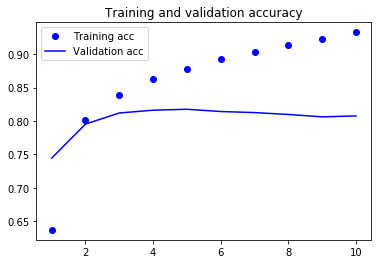

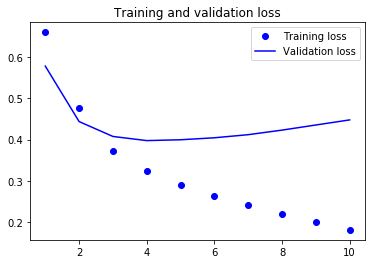

In [62]:
output_plots(history)

So, with just the embedding we get a classifier that can get 76% of the reviews correct (not bad, given the simplicity of the model - that we treat each word separately and don't consider inter-word relationships or sentence structure - and that we're only using the first 20 words of the review). I tried changing to the first 50 words and got to 80%.

## Using pre-trained embeddings instead of creating our own and downloading and using the raw text instead of pre-tokenized IMDB data from Keras

In [67]:
import os

imdb_dir = 'D:\\work\\data\\aclImdb_v1\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [88]:
import sys

labels = []
texts = []

# get one string per review, along w/ 0s and 1s for labels
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        #print(dir_name, fname)
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            #f = open(os.path.join(dir_name, fname))
            
            # handle bad chars that we can't read (could also figure out how to read them)
            # to read them, i just need to not use the Windows OS default charmap encoding and instead specify
            # encoding='utf-8' in the open call above.
            try:
                texts.append(f.read())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
            except UnicodeDecodeError as ude:
                print(dir_name, fname)
                print(sys.exc_info()[0], sys.exc_info()[1], sys.exc_info()[2])
            finally:
                f.close()
                
len(labels), len(texts)

(25000, 25000)

In [89]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [90]:
labels[1]

0

And vectorize/tokenize the text, and get a training/validation split. Since the point of using pre-trained embeddings is to help when we have very small numbers of input data (otherwise training our own task/label-specific embedding may be better) we'll only use the first 200 samples to train our simple model.  

In [119]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # use only the first 100 words of each review
training_samples = 200
validation_samples = 10000
# training_samples = 10000
# validation_samples = 2000

max_words = 10000 # use only the top 10K most common words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print(f'Shape of data tensor: {data.shape}')
print(f'Shape of label tensor: {labels.shape}')

indices = np.arange(data.shape[0]) # first shuffle the data before doing the split, since by def all negative are first
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88580 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [111]:
len(sequences)

25000

In [112]:
sequences[0][:10]

[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3]

The data var is shuffled after sequences so I don't think they'll match up.

In [113]:
data[0]

array([   1,  201,  281,    2,  201,  520,   10, 2743,   38,  400,   35,
         11,   17,  211,    1, 2233,   43,    4,  744,  672,   21,    3,
         19,   12,   22,   67,  866,  177,    2,  103,    2,  355,   11,
          6,    3,   19,   12,   22,  468,    5,  157, 1305,   39,  190,
          9,  142,    5,    1, 2018,   45, 2628,   39, 1244,    9,   13,
         49,    5,   64, 4194,    1, 4194,  142,   18,  283,   14,  250,
         14,    1,   83,   33,  141,    4,   66,    1,  159,  739,   14,
       5922,  489, 2067,   53,    2,  128,   66,    2, 4806,   38,  390,
          8,    1,   19,   12, 2530,   74,    3,  224,  125,   92,    9,
         13])

In [114]:
labels[0]

0

Ok, so now I think we have what we had before when we used the pre-tokenized data from Keras - we have a set of observations/reviews, each of which has 100 integers, where each integer represents the index of a word in the entire set of top 10K words/tokens.

Now we'll handle the GloVe embeddings, which includes a 100-dimensional embedding for 400K words/tokens - i.e., for each of the 400K words/tokens, I think we get the location in a 100D space. In the downloaded data, this is in glove.6B.100d.txt. 

In [96]:
glove_dir = 'D:\\work\\data\\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [99]:
len(embeddings_index), type(embeddings_index)

(400000, dict)

In [101]:
len(embeddings_index['and']), embeddings_index['and']

(100,
 array([-0.071953,  0.23127 ,  0.023731, -0.50638 ,  0.33923 ,  0.1959  ,
        -0.32943 ,  0.18364 , -0.18057 ,  0.28963 ,  0.20448 , -0.5496  ,
         0.27399 ,  0.58327 ,  0.20468 , -0.49228 ,  0.19974 , -0.070237,
        -0.88049 ,  0.29485 ,  0.14071 , -0.1009  ,  0.99449 ,  0.36973 ,
         0.44554 ,  0.28998 , -0.1376  , -0.56365 , -0.029365, -0.4122  ,
        -0.25269 ,  0.63181 , -0.44767 ,  0.24363 , -0.10813 ,  0.25164 ,
         0.46967 ,  0.3755  , -0.23613 , -0.14129 , -0.44537 , -0.65737 ,
        -0.042421, -0.28636 , -0.28811 ,  0.063766,  0.20281 , -0.53542 ,
         0.41307 , -0.59722 , -0.38614 ,  0.19389 , -0.17809 ,  1.6618  ,
        -0.011819, -2.3737  ,  0.058427, -0.2698  ,  1.2823  ,  0.81925 ,
        -0.22322 ,  0.72932 , -0.053211,  0.43507 ,  0.85011 , -0.42935 ,
         0.92664 ,  0.39051 ,  1.0585  , -0.24561 , -0.18265 , -0.5328  ,
         0.059518, -0.66019 ,  0.18991 ,  0.28836 , -0.2434  ,  0.52784 ,
        -0.65762 , -0.14081 ,  1

In [102]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [103]:
embedding_matrix.shape

(10000, 100)

In [105]:
embedding_matrix[5], len(embedding_matrix[5])

(array([-1.89700007e-01,  5.00239991e-02,  1.90840006e-01, -4.91839983e-02,
        -8.97369981e-02,  2.10060000e-01, -5.49520016e-01,  9.83769968e-02,
        -2.01350003e-01,  3.42409998e-01, -9.26769972e-02,  1.60999998e-01,
        -1.32679999e-01, -2.81599998e-01,  1.87370002e-01, -4.29589987e-01,
         9.60389972e-01,  1.39719993e-01, -1.07809997e+00,  4.05180007e-01,
         5.05389988e-01, -5.50639987e-01,  4.84400004e-01,  3.80439997e-01,
        -2.90549989e-03, -3.49420011e-01, -9.96960029e-02, -7.83680022e-01,
         1.03629994e+00, -2.31399998e-01, -4.71210003e-01,  5.71259975e-01,
        -2.14540005e-01,  3.59580010e-01, -4.83190000e-01,  1.08749998e+00,
         2.85239995e-01,  1.24470003e-01, -3.92480008e-02, -7.67320022e-02,
        -7.63429999e-01, -3.24090004e-01, -5.74899971e-01, -1.08930004e+00,
        -4.18110013e-01,  4.51200008e-01,  1.21119998e-01, -5.13670027e-01,
        -1.33489996e-01, -1.13779998e+00, -2.87680000e-01,  1.67740002e-01,
         5.5

In [120]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


The above creates an Embedding layer, but it starts w/ random weights and we want to use the weights from the pre-trained embedding data. Here's how...

In [121]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [122]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.2462 - acc: 0.5350 - val_loss: 0.7585 - val_acc: 0.5003
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6526 - acc: 0.6150 - val_loss: 0.7225 - val_acc: 0.5044
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4654 - acc: 0.8450 - val_loss: 1.3322 - val_acc: 0.4995
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4081 - acc: 0.9050 - val_loss: 0.7212 - val_acc: 0.5045
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3231 - acc: 0.8850 - val_loss: 0.7249 - val_acc: 0.5042
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3028 - acc: 0.8950 - val_loss: 0.9636 - val_acc: 0.4996
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1867 - acc: 0.9600 - val_loss: 1.0555 - val_acc: 0.4987
Epoch 8/10
200/200 [========

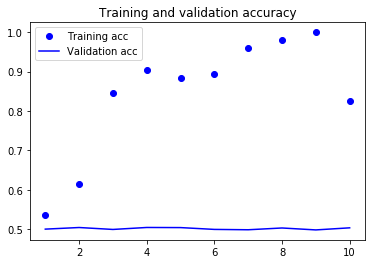

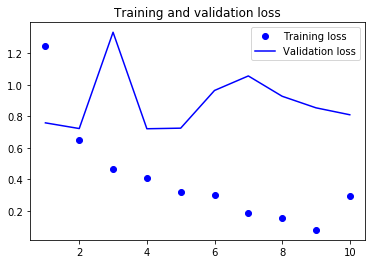

In [123]:
output_plots(history)

I get around 50% accuracy w/ 200 training samples, and when I change it to 10K samples I don't get much better - maybe 52-53% 

There's a bit more in the book about comparing training your own task-specific embedding, and also using the model to get a score w/ the test data. In none of them do we get better than around 55%, which the book puts down to only using 200 training samples (although I wonder if it's also the model - I used 10K and saw about the same - and how much doing something more sophisticated w/ the structure - more than just an embedding layer - would help).

# Recurrent neural networks, introduced